In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import tensorflow as tf
keras = tf.keras
from keras.preprocessing.text import Tokenizer



from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Flatten, Dense

from sklearn.model_selection import train_test_split

from pipeline import vector_comparison

import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


In [3]:
from pipeline import vector_comparison

In [4]:
df = pd.read_csv('data/training.csv', index_col = 0)
#df = df.iloc[:1000] #need to limit rows while running on local machine.

In [5]:
token = Tokenizer()
model = vector_comparison(df)
X_train, X_test = model.split_data(['question1','question2'], 'is_duplicate') # ran to get self.fitting_text

y_train = model.y_train

token.fit_on_texts(model.fitting_text)
seq1 = token.texts_to_sequences(X_train['question1'].values)
seq2 = token.texts_to_sequences(X_train['question2'].values)


#vsalidation data

y_val = model.y_test

token.fit_on_texts(model.fitting_text)
seq1_val = token.texts_to_sequences(X_test['question1'].values)
seq2_val = token.texts_to_sequences(X_test['question2'].values)


In [6]:
vocab_size = len(token.index_word) + 1

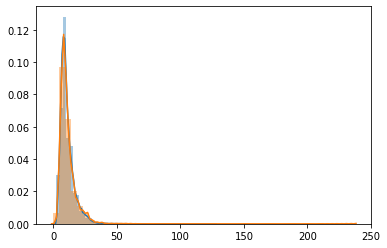

In [7]:

#average querstion lenght to set max_len
def seq_dist(seq1, seq2):
    temp1, temp2 = [], []
    for i in seq1:
        temp1.append(len(i))
    for i in seq2:
        temp2.append(len(i))
    sns.distplot(temp1)
    sns.distplot(temp2)
    return np.mean(temp1), np.mean(temp1)

seq_dist(seq1, seq2)

max_len = 30

In [8]:
from keras.preprocessing.sequence import pad_sequences

seq1_pad = pad_sequences(seq1, maxlen = max_len, padding ='pre')
seq2_pad = pad_sequences(seq2, maxlen = max_len, padding ='pre')

seq1_pad_val =pad_sequences(seq1_val, maxlen = max_len, padding ='pre')
seq2_pad_val =pad_sequences(seq2_val, maxlen = max_len, padding ='pre')

In [10]:
input_1 = Input(shape=(seq1_pad.shape[1],))
input_2 = Input(shape=(seq2_pad.shape[1],))


from keras.layers import Input, LSTM, Flatten, Dense, Concatenate, Multiply, Dropout, Subtract, Add, Embedding, Activation
from keras.layers.core import Lambda 

from sklearn.metrics import roc_auc_score as auroc

from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [11]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('src/glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embeded_dim = len(embeddings_index['the'])
print('Loaded %s word vectors.' % len(embeddings_index))



Loaded 400000 word vectors.


In [12]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, embeded_dim))
for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)

In [14]:
common_lstm_1 = LSTM(100,return_sequences=True, activation="tanh")
common_lstm_2 = LSTM(100,return_sequences=True, activation="tanh")

In [49]:
lstm_1 = e(input_1)
lstm_2 = e(input_2)

#seq1 path
vector_1 = common_lstm_1(lstm_1)
vector_1 = common_lstm_2(vector_1)
vector_1 = Flatten()(vector_1)

#seq2 path
vector_2 = common_lstm_1(lstm_2)
vector_2 = common_lstm_2(vector_2)
vector_2 = Flatten()(vector_2)

cosine_sim = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

x = Dense(100, activation="tanh", name='conc_layer')(cosine_sim)
x = Dropout(0.01)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], cosine_sim)

model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

In [50]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 300)      22570200    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 30, 100)      160400      embedding_1[6][0]          

In [51]:
model.fit([seq1_pad,seq2_pad],y_train.values.reshape(-1,1), epochs = 5, batch_size = 5000,
          validation_data=([seq1_pad_val,seq2_pad_val],y_val.values.reshape(-1,1)))


Train on 242608 samples, validate on 80870 samples
Epoch 1/5
 35000/242608 [===>..........................] - ETA: 3:25 - loss: 5.6030 - acc: 0.6292

KeyboardInterrupt: 

In [31]:
1 - y_train.sum()/len(y_train)

0.6303419508012926

In [43]:
vocab_size

75234

In [38]:
embedding_matrix.shape

(75234, 300)

In [46]:
len(embeddings_index.keys())

400000

In [48]:
embeddings_index['the'].shape

(300,)